## Семинар 7: "Методы оптимизации"

ФИО: Висков Василий

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
import torch
from torch import nn
from torch import functional as F
from torch.autograd import Variable

%matplotlib notebook
import seaborn
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [2]:
class Optimizer():
    def __init__(self, variables):
        self.variables = variables
        
    def step(self, loss):
        pass
    
class GD(Optimizer):
    def __init__(self, variables, learning_rate=0.1):
        super().__init__(variables)
        self.lr = learning_rate
        
    def step(self, J):
        loss = J()
        loss.backward()
        with torch.no_grad():
            for v in self.variables:
                v -= self.lr * v.grad
                v.grad.data.zero_()
                
class Momentum(Optimizer):
    def __init__(self, variables, learning_rate=0.01, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g
                moment += self.lr * v.grad
                v -= moment
                v.grad.data.zero_()
                
class NAG(Optimizer):
    def __init__(self, variables, learning_rate=0.01, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g                
                v -= moment
        loss = J()
        loss.backward()
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                v += moment
                moment += self.lr * v.grad
                v -= moment
                v.grad.data.zero_()
                
class Adagrad(Optimizer):
    def __init__(self, variables, learning_rate=0.5, eps=10**-8):
        super().__init__(variables)
        self.lr = learning_rate
        self.eps = eps
        self.g_sq = []
        for v in self.variables:
            self.g_sq.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        with torch.no_grad():
            for v, g_sq in zip(self.variables, self.g_sq):      
                g_sq += v.grad**2
                v -= self.lr / (g_sq + self.eps).sqrt() * v.grad
                v.grad.data.zero_()


class Adadelta(Optimizer):
    def __init__(self, variables, learning_rate=0.1, eps=10**-8, gamma=0.9):
        super().__init__(variables)
        self.eps = eps
        self.gamma = gamma
        self.lr = learning_rate
        self.rms_g = []
        self.rms_t = []
        self.prev_rms_t = (self.lr - self.eps) ** 2
        for v in self.variables:
            self.rms_g.append(torch.zeros_like(v.data))
            self.rms_t.append(torch.zeros_like(v.data))

    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, rms_g, rms_t in zip(self.variables, self.rms_g, self.rms_t):
                rms_g = self.gamma * rms_g + (1 - self.gamma) * (v.grad ** 2)
                delta = ((self.prev_rms_t + self.eps) / (rms_g + self.eps)).sqrt() * v.grad
                rms_t = self.gamma * rms_t + (1 - self.gamma) * (delta ** 2)
                self.prev_rms_t = rms_t
                v -= delta
                v.grad.data.zero_()

class Adam(Optimizer):
    def __init__(self, variables, learning_rate=0.1, b1=0.9, b2=0.999, eps=10**-8):
        super().__init__(variables)
        self.b1 = b1
        self.b2 = b2
        self.eps = eps
        self.lr = learning_rate
        self.m = []
        self.nu = []
        
        for v in self.variables:
            self.m.append(torch.zeros_like(v.data))
            self.nu.append(torch.zeros_like(v.data))
    
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, m, nu in zip(self.variables, self.m, self.nu):
                m = self.b1 * m + (1 - self.b1) * v.grad
                nu = self.b2 * nu + (1 - self.b2) * v.grad ** 2
                m /= 1 - self.b1
                nu /= 1 - self.b2
                v -= self.lr * m / (nu + self.eps).sqrt()
                v.grad.data.zero_()

In [3]:
def apply_opt(optimizer, j, n_iters=1000):    
    points = []
    
    x = np.random.randint(6, 9, 1)
    y = np.random.randint(6, 9, 1)

    X = Variable(torch.tensor(float(x)), requires_grad=True)
    Y = Variable(torch.tensor(float(y)), requires_grad=True) 
    
    opt = optimizer([X, Y])
    J = lambda X=X, Y=Y: j(X, Y)
    
    for i in range(n_iters):
        points.append((X.item(), Y.item(), J().item()))
        opt.step(J)

    points = np.array(points)
    return points

In [4]:
def view(J, optimizers):
    fig = plt.figure(figsize=(7, 7))
    R = 10
    X = np.linspace(-R, R, 100)
    Y = np.linspace(-R, R, 100)
    xx, yy = np.meshgrid(X, Y)
    xx = torch.from_numpy(xx)
    yy = torch.from_numpy(yy)
    Z = J(xx, yy)
    
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d(-R, +R)
    ax.set_ylim3d(-R, +R)
    ax.set_zlim3d(-R, +R)
    ax.plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy(), color='xkcd:beige')

    for opt in optimizers:
        points = apply_opt(lambda x: opt(x), J, 500)
        ax.plot(points[:, 0], points[:, 1], points[:, 2], label=opt.__name__, linewidth=3)

    plt.legend(fontsize=8)
    plt.show()

In [5]:
optimizers = [GD, 
              Momentum,
              NAG, 
              Adagrad, 
              Adadelta,
              Adam]

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [6]:
def J1(X, Y):
    return X ** 2 / 10 + Y ** 2 / 10

<IPython.core.display.Javascript object>


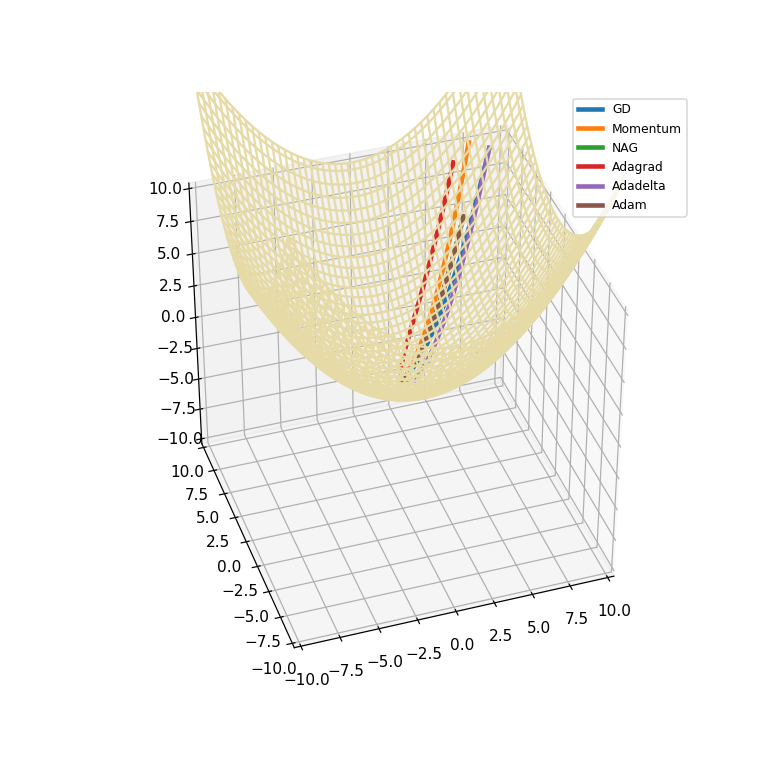

In [7]:
view(J1, optimizers)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [8]:
def J2(X, Y):
    return (X ** 2 * X.sin() + Y ** 2 * Y.sin()) / 10

<IPython.core.display.Javascript object>


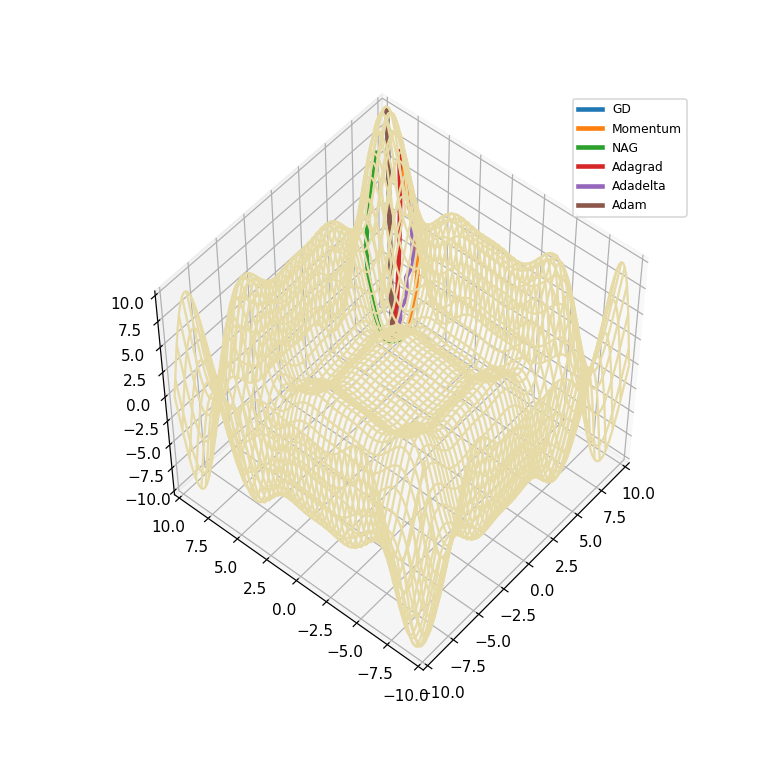

In [9]:
view(J2, optimizers)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [10]:
def J3(X, Y):
    C = 16
    return (X ** 2 * (X ** 2 / C).sin() + Y ** 2 * (Y ** 2 / C).sin()) / C

<IPython.core.display.Javascript object>


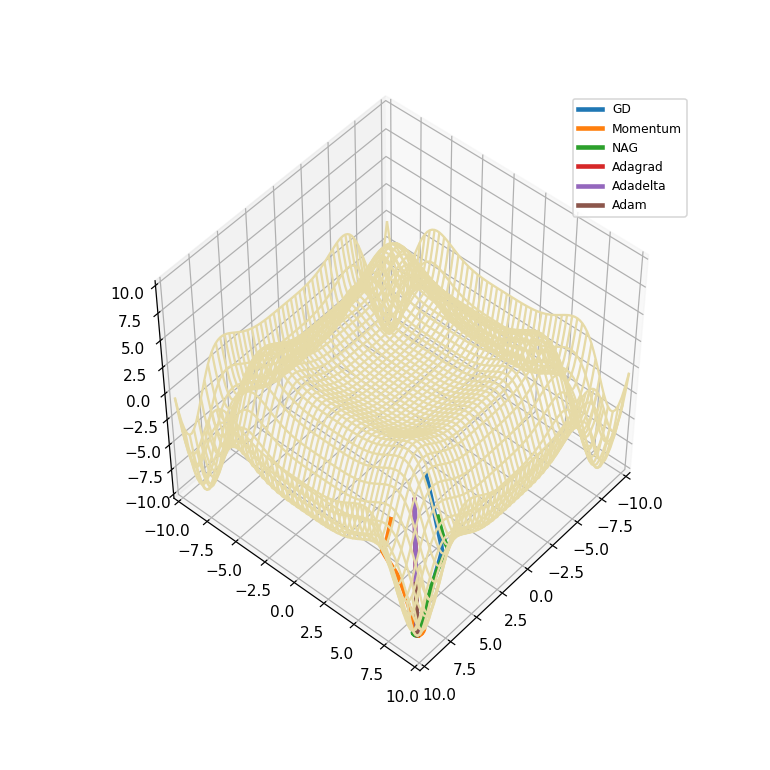

In [11]:
view(J3, optimizers)

###  Часть 2: Обучение нейронной сети

In [12]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from IPython.display import clear_output

In [13]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [15]:
loss = nn.NLLLoss()
optimizers = [torch.optim.Adam, torch.optim.Adagrad, torch.optim.Adadelta, torch.optim.SGD]

In [16]:
def train(network, epochs, learning_rate, loss, optimizer):
    optimizer = optimizer(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print(type(optimizer).__name__)
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, test_loss_epochs

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [17]:
class FullClf(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 200), 
                                           nn.ELU(),
                                           nn.Linear(200, 100),
                                           nn.ELU(),
                                           nn.Linear(100, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [18]:
%%time
trains = []
tests = []

for optimizer in optimizers:
    network = FullClf()
    train_loss_epochs, test_loss_epochs = train(network, 5, 1e-3, loss, optimizer)
    trains.append(train_loss_epochs)
    tests.append(test_loss_epochs)

SGD
Epoch 4... (Train/Test) NLL: 0.358/0.331	Accuracy: 0.898/0.904
Wall time: 8min 26s


<IPython.core.display.Javascript object>


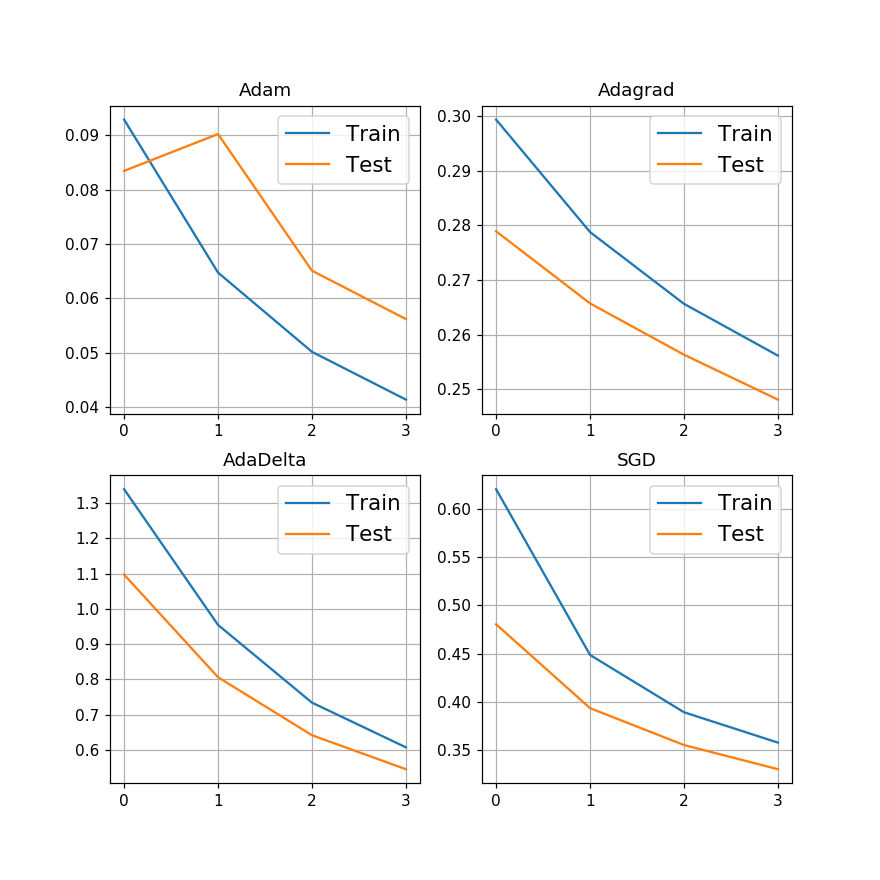

In [19]:
fig = plt.figure(figsize=(8, 8))
titles = ['Adam', 'Adagrad', 'AdaDelta', 'SGD']
ax = []

for i in range(len(optimizers)):
    ax.append(fig.add_subplot(221 + i))
    ax[i].plot(trains[i][1:], label='Train')
    ax[i].plot(tests[i][1:], label='Test')
    ax[i].legend(loc=1, fontsize=14)
    ax[i].grid()
    ax[i].set_title(titles[i])

plt.show()

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [20]:
class ConvClf(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, (3, 3), padding=1), nn.ReLU(),
                                         nn.Conv2d(8, 16, (3, 3), padding=1), nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, (3, 3), padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*32, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [21]:
%%time
trains = []
tests = []

for optimizer in optimizers:
    network = ConvClf(28)
    train_loss_epochs, test_loss_epochs = train(network, 5, 1e-4, loss, optimizer)
    trains.append(train_loss_epochs)
    tests.append(test_loss_epochs)

SGD
Epoch 4... (Train/Test) NLL: 0.255/0.221	Accuracy: 0.927/0.936
Wall time: 51min 29s


<IPython.core.display.Javascript object>


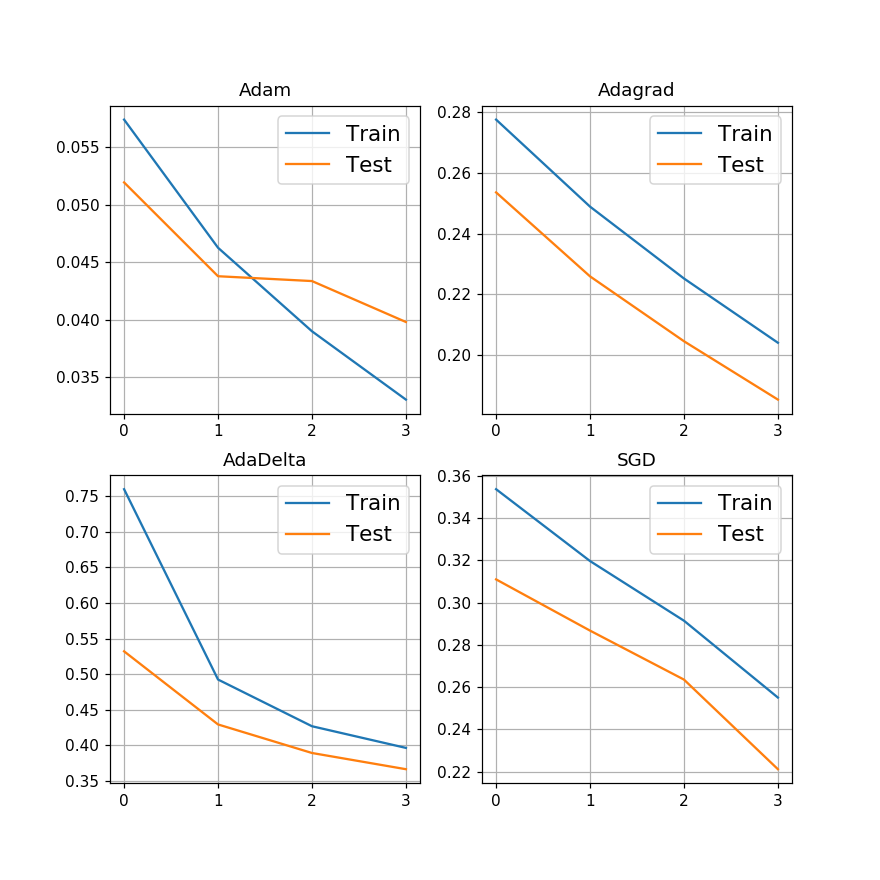

In [22]:
fig = plt.figure(figsize=(8, 8))
titles = ['Adam', 'Adagrad', 'AdaDelta', 'SGD']
ax = []

for i in range(len(optimizers)):
    ax.append(fig.add_subplot(221 + i))
    ax[i].plot(trains[i][1:], label='Train')
    ax[i].plot(tests[i][1:], label='Test')
    ax[i].legend(loc=1, fontsize=14)
    ax[i].grid()
    ax[i].set_title(titles[i])

plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: